In [ ]:
#!/usr/bin/env python3
"""
Baixa a rede OSM (motorway | trunk | primary) estado-a-estado,
gera sub-grafos por UF e monta um grafo nacional.

Estrutura de cache:
• cache/osmnx_cache/   – .json das respostas Overpass (reaproveitados)
• cache/parc_estados/  – sub-grafos .graphml por UF
• cache/graph_Brazil.graphml – grafo BR consolidado
"""

from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import hashlib, osmnx as ox, networkx as nx, gc

# ───────── parâmetros ─────────
UF_LIST = [
    "AC","AL","AP","AM","BA","CE","DF","ES","GO","MA","MT",
    "MS","MG","PA","PB","PR","PE","PI","RJ","RN","RS",
    "RO","RR","SC","SP","SE","TO"
]
FILTER        = '["highway"~"motorway|trunk|primary"]'
MAX_WORKERS   = 8

CACHE_DIR     = Path("cache");                CACHE_DIR.mkdir(exist_ok=True)
CACHE_JSON    = CACHE_DIR / "osmnx_cache";    CACHE_JSON.mkdir(exist_ok=True)
PARC_DIR      = CACHE_DIR / "parc_estados";   PARC_DIR.mkdir(exist_ok=True)
GRAPH_FINAL   = CACHE_DIR / "graph_Brazil.graphml"

# ───────── OSMnx config global ───────
ox.settings.use_cache    = True
ox.settings.cache_folder = str(CACHE_JSON)
ox.settings.timeout      = 900                # 15 min

# ─── se grafo final já existe: imprime resumo e sai ───
if GRAPH_FINAL.exists():
    print("⚡  Grafo pronto –", GRAPH_FINAL)
    G = ox.load_graphml(GRAPH_FINAL)
    print(f"• Nós   : {G.number_of_nodes():,}")
    print(f"• Arestas: {G.number_of_edges():,}")
    quit()

# hash curtinho para nome dos sub-arquivos
_hash12 = lambda s: hashlib.md5(s.encode()).hexdigest()[:12]

def baixar_uf(sigla: str):
    """Baixa (ou lê) o grafo de uma UF; devolve networkx.Graph ou None."""
    parc_file = PARC_DIR / f"{sigla}_{_hash12(sigla)}.graphml"
    if parc_file.exists():
        return ox.load_graphml(parc_file)

    try:
        g = ox.graph_from_place(
                f"Brazil, {sigla}",
                network_type="drive",
                custom_filter=FILTER,
                simplify=True,
                retain_all=False,
        )
        # adiciona comprimento se necessário (compatível com OSMnx ≥1.1 ou ≤1.0)
        if any("length" not in data for _, _, data in g.edges(data=True)):
            try:
                g = ox.add_edge_lengths(g)          # OSMnx ≥ 1.1
            except AttributeError:
                g = ox.distance.add_edge_lengths(g) # OSMnx 1.0

        ox.save_graphml(g, parc_file)
        return g

    except Exception as exc:
        print(f"⚠  {sigla}: {exc}")
        return None

print(f"🌐  Baixando {len(UF_LIST)} estados com {MAX_WORKERS} threads…")
grafs = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as pool:
    tasks = {pool.submit(baixar_uf, uf): uf for uf in UF_LIST}
    for fut in as_completed(tasks):
        uf = tasks[fut]
        g  = fut.result()
        if g:
            print(f"✓ {uf:>2}  nós={len(g):,}")
            grafs.append(g)

if not grafs:
    raise RuntimeError("Nenhum estado baixado – verifique conexão/limites.")

print("\n🔗  Unificando grafos…")
G = nx.compose_all(grafs)
del grafs                      # libera RAM antes de salvar
gc.collect()

G.remove_nodes_from(list(nx.isolates(G)))
ox.save_graphml(G, GRAPH_FINAL)
print(f"\n✔ Grafo final salvo em {GRAPH_FINAL.resolve()}")

# --- resumo rápido --------------------------
print(f"• Nós   : {G.number_of_nodes():,}")
print(f"• Arestas: {G.number_of_edges():,}")

⚡  Grafo pronto – cache/graph_Brazil.graphml
• Nós   : 172,627
• Arestas: 265,510
🌐  Baixando 27 estados com 8 threads…
✓ AP  nós=291
✓ AM  nós=680
✓ AC  nós=380
✓ AL  nós=1,792
✓ ES  nós=3,352
✓ MT  nós=3,312
✓ MA  nós=2,834
✓ DF  nós=4,465
✓ MS  nós=3,834
✓ CE  nós=5,380
✓ GO  nós=9,724
✓ PA  nós=1,825
✓ BA  nós=7,715
✓ PI  nós=2,210
✓ PB  nós=2,355
✓ RR  nós=341
✓ RO  nós=903
✓ PE  nós=4,663
✓ RN  nós=2,413
✓ SE  nós=1,404
✓ TO  nós=1,952
✓ PR  nós=13,707
✓ RJ  nós=8,675
✓ RS  nós=12,100
✓ SC  nós=8,568
✓ MG  nós=18,822
✓ SP  nós=48,938

🔗  Unificando grafos…

✔ Grafo final salvo em /Users/enzooliveira/Pessoal/VS CODE/9semestre/otimizacao/cache/graph_Brazil.graphml
• Nós   : 172,627
• Arestas: 265,510


: 

In [ ]:
# ───────────────── download ANTT 2024 ─────────────────
from pathlib import Path
import requests, gzip, ckanapi, io, zipfile

DATA_DIR = Path("dados")
DATA_DIR.mkdir(exist_ok=True)
CSV_PATH = DATA_DIR / "antt_2024.csv"      # arquivo que ficará descompactado

if CSV_PATH.exists():
    print("✔  já existe:", CSV_PATH.resolve())
else:
    ANTT_URL = "https://dados.antt.gov.br"
    ANTT_PKG = "volume-trafego-praca-pedagio"

    # 1) localiza o resource “CSV – 2024” no CKAN
    ckan = ckanapi.RemoteCKAN(ANTT_URL, user_agent="python-ckan")
    pkg  = ckan.action.package_show(id=ANTT_PKG)
    res  = next(r for r in pkg["resources"]
                if "2024" in r["name"].lower() and r["format"].lower() == "csv")
    url  = res["url"]
    print("⬇  baixando:", url)

    # 2) baixa o payload
    raw = requests.get(url, timeout=120).content

    # 3) se o payload estiver em gzip (0x1f 0x8b), descompacta
    if raw[:2] == b"\x1f\x8b":
        raw = gzip.decompress(raw)

    # 4) grava em disco
    CSV_PATH.write_bytes(raw)
    print("✔  salvo em", CSV_PATH.resolve())

/Users/enzooliveira/micromamba/envs/ChargerPoints/lib/python3.11/site-packages/ckanapi/version.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


⬇  baixando: https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/7f622637-a442-4f3c-8360-aebc41806ca3/download/volume-trafego-praca-pedagio-2024.csv


KeyboardInterrupt: 

In [14]:
import pandas as pd, textwrap, pathlib

csv = pathlib.Path("dados/antt_2024.csv")

# lê só a linha de cabeçalho
hdr = pd.read_csv(
    csv,
    sep=";",              # o arquivo da ANTT usa ponto-e-vírgula
    engine="python",      # parser tolerante
    encoding="latin1",    # ← chave!  evita o UnicodeDecodeError
    nrows=0               # lê só o header
)

print("Colunas encontradas:")
print(textwrap.fill(" | ".join(hdr.columns), width=120))

Colunas encontradas:
concessionaria | mes_ano | sentido | praca | tipo_cobranca | categoria_eixo | tipo_de_veiculo | volume_total


In [16]:
# ───────── baixar último CSV de volume de tráfego da ANTT ─────────
from pathlib import Path
import re, requests, gzip, io, zipfile, ckanapi, pandas as pd, textwrap

BASE_DIR = Path("dados");  BASE_DIR.mkdir(exist_ok=True)

def baixar_csv_antt_mais_recente() -> Path:
    CKAN  = ckanapi.RemoteCKAN("https://dados.antt.gov.br",
                               user_agent="python-ckan")
    pkg   = CKAN.action.package_show(id="volume-trafego-praca-pedagio")

    # escolhe o CSV de MAIOR ano no nome
    res   = max(
        (r for r in pkg["resources"] if r["format"].lower() == "csv"),
        key=lambda r: int(re.search(r"(\d{4})", r["name"]).group(1))
    )
    ano   = re.search(r"(\d{4})", res["name"]).group(1)
    url   = res["url"]
    print(f"⬇  baixando CSV {ano}: {url}")

    raw = requests.get(url, timeout=120).content
    if raw[:2] == b"\x1f\x8b":               # gzip magic bytes
        raw = gzip.decompress(raw)

    csv_path = BASE_DIR / f"antt_{ano}.csv"
    csv_path.write_bytes(raw)
    print("✔  salvo em", csv_path.resolve())
    return csv_path

csv_file = baixar_csv_antt_mais_recente()

# ───────── ver só o cabeçalho ─────────
hdr = pd.read_csv(csv_file,
                  sep=";",              # arquivo ANTT usa ;
                  engine="python",      # parser tolerante
                  encoding="latin1",    # evita UnicodeDecodeError
                  nrows=0)              # só a 1ª linha

print("\nColunas encontradas:")
print(textwrap.fill(" | ".join(hdr.columns), width=120))

⬇  baixando CSV 2025: https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/183e346e-6f87-4bb2-9bf3-4b53f3bbe4e4/download/volume-trafego-praca-pedagio-2025.csv
✔  salvo em /Users/enzooliveira/Pessoal/VS CODE/9semestre/otimizacao/dados/antt_2025.csv

Colunas encontradas:
concessionaria | mes_ano | sentido | praca | tipo_cobranca | categoria_eixo | tipo_de_veiculo | volume_total


In [21]:
# 01_cadastro_pracas.py  ───────────────────────────────────────────
from pathlib import Path
import pandas as pd, textwrap

DATA_DIR   = Path("dados")
CACHE_DIR  = Path("cache"); CACHE_DIR.mkdir(exist_ok=True)

csv_path   = DATA_DIR / "cadastro_pracas.csv"
parq_path  = CACHE_DIR / "cadastro_pracas.parquet"

# ──────────────────────────────────────────────────────────────────
# 1) leitura robusta (CSV usa ; e Latin-1)
if not csv_path.exists():
    raise FileNotFoundError(f"Arquivo {csv_path} não encontrado. "
                            "Coloque o CSV baixado nesse caminho.")

cad = pd.read_csv(
    csv_path,
    sep=";",             # separador usado pela ANTT
    encoding="latin1",   # evita UnicodeDecodeError
    engine="python",     # parser tolerante
)

# ──────────────────────────────────────────────────────────────────
# 2) padroniza cabeçalhos
cad.columns = cad.columns.str.strip().str.lower()

rename_map = {
    "praca_de_pedagio": "praca",
    "praca":            "praca",     # caso já venha certo
    "rodovia":          "br",
    "br":               "br",
    "km_m":             "km",
    "quilometro":       "km",
    "latitude":         "lat",
    "longitude":        "lon",
}
cad = cad.rename(columns={k: v for k, v in rename_map.items() if k in cad.columns})

# mantém apenas as colunas de interesse
keep = ["praca", "br", "km", "lat", "lon"]
cad = cad[[c for c in keep if c in cad.columns]]

# normaliza texto/numérico
cad["praca"] = cad["praca"].str.strip().str.upper()
cad["br"]    = cad["br"].str.strip().str.upper()
cad["km"]    = pd.to_numeric(cad["km"], errors="coerce")

# ──────────────────────────────────────────────────────────────────
# 3) salva Parquet
cad.to_parquet(parq_path, index=False)
print(f"✔ Cadastro de praças salvo em {parq_path}  –  {len(cad):,} linhas")

# ──────────────────────────────────────────────────────────────────
# 4) espiada opcional
print("\nPré-visualização:")
print(textwrap.indent(cad.head().to_string(index=False), "  "))

✔ Cadastro de praças salvo em cache/cadastro_pracas.parquet  –  246 linhas

Pré-visualização:
                            praca     br  km        lat        lon
  1 NORTE - DEFASADA (MAIRIPORÃ£) BR-381 NaN -23,341210 -46,573664
             1 NORTE (MAIRIPORÃ£) BR-381 NaN -23,322298 -46,581097
               1 SUL (MAIRIPORÃ£) BR-381 NaN -23,330558 -46,578337
                       2 (VARGEM) BR-381 NaN -22,908685 -46,424877
                      3 (CAMBUÃ­) BR-381 NaN -22,628487 -46,077890


In [36]:
# 0_vmda_dump.py  ── minifix VMDA-2023
from pathlib import Path
import pandas as pd, textwrap, re

DATA_DIR = Path("dados")
XLSX_IN  = DATA_DIR / "VMDA 2023.xlsx"
CSV_OUT  = DATA_DIR / "vmda_2023_raw.csv"

# 1) Abas disponíveis ----------------------------------------------------------
xls = pd.ExcelFile(XLSX_IN, engine="openpyxl")

print("Índice | Nome da aba")
for i, s in enumerate(xls.sheet_names):
    print(f"{i:>5}  -  {s}")

# 2) Escolha automática: pega a primeira aba cujo nome contenha “SNV”
try:
    SHEET_IDX = next(
        i for i, s in enumerate(xls.sheet_names)
        if re.search(r"snv", s, flags=re.I)
    )
except StopIteration:
    SHEET_IDX = 0                      # fallback: primeira aba

print(f"\n→ Lendo aba #{SHEET_IDX}: {xls.sheet_names[SHEET_IDX]!r}")

# 3) Carrega a aba escolhida ---------------------------------------------------
df = xls.parse(sheet_name=SHEET_IDX)

# 4) Salva CSV bruto com separador “;” ----------------------------------------
CSV_OUT.parent.mkdir(exist_ok=True)
df.to_csv(CSV_OUT, index=False, sep=";")

print(f"\n✔ CSV bruto salvo em {CSV_OUT.resolve()}")
print("\nColunas:")
print(textwrap.fill(" | ".join(map(str, df.columns)), width=110))

print("\nAmostra:")
print(textwrap.indent(df.head().to_string(index=False), "  "))

Índice | Nome da aba
    0  -  Metadados
    1  -  SNV202401A

→ Lendo aba #1: 'SNV202401A'

✔ CSV bruto salvo em /Users/enzooliveira/Pessoal/VS CODE/9semestre/otimizacao/dados/vmda_2023_raw.csv

Colunas:
ID | id_trecho_ | vl_br | sg_uf | nm_tipo_tr | sg_tipo_tr | desc_coinc | vl_codigo | ds_local_i | ds_local_f |
vl_km_inic | vl_km_fina | vl_extensa | vl_km_i_estim | vl_km_f_estim | vl_ext_estim | ds_sup_fed | ds_obra |
ul | ds_coinc | ds_tipo_ad | ds_ato_leg | est_coinc | sup_est_co | ds_jurisdi | ds_superfi | ds_legenda |
sg_legenda | leg_multim | versao_snv | id_versao | classificação | GEH | A_C | B_C | C_C | D_C | E_C | F_C |
G_C | H_C | I_C | J_C | A_D | B_D | C_D | D_D | E_D | F_D | G_D | H_D | I_D | J_D | VMDa_C | VMDa_D

Amostra:
   ID  id_trecho_  vl_br sg_uf     nm_tipo_tr sg_tipo_tr desc_coinc  vl_codigo                             ds_local_i                             ds_local_f  vl_km_inic  vl_km_fina  vl_extensa  vl_km_i_estim  vl_km_f_estim  vl_ext_estim ds_sup_fed ds

In [38]:
# 3_processa_dnit_vmda.py  ────────────────────────────────────
from pathlib import Path
import pandas as pd, re, textwrap

# ───────── paths ─────────────────────────────────────────────
DATA_DIR  = Path("dados")
CACHE_DIR = Path("cache"); CACHE_DIR.mkdir(exist_ok=True)

CSV_IN  = DATA_DIR / "vmda_2023_raw.csv"        # dump bruto (CSV ; Latin-1)
OUT_PQ  = CACHE_DIR / "dnit_vmda_2023.parquet"  # saída final

# ───────── 1. leitura ───────────────────────────────────────
df = pd.read_csv(CSV_IN, sep=";", encoding="latin1", engine="python")
df.columns = df.columns.str.strip().str.lower()

# ───────── 2. renomeia colunas básicas ──────────────────────
col_map = {
    "vl_br"       : "br",
    "vl_km_inic"  : "km",     # km inicial → preferencial
    "vl_km_fina"  : "km_f",   # km final  → backup
    "vmda_c"      : "vmd_c",
    "vmda_d"      : "vmd_d",
    "vmd_c"       : "vmd_c",  # casos sem “a” minúsculo
    "vmd_d"       : "vmd_d",
}
df = df.rename(columns={k: v for k, v in col_map.items() if k in df.columns})

# ───────── 3. resolve km duplicados ─────────────────────────
if "km" in df.columns and "km_f" in df.columns:
    # usa km_inic; se nulo, completa com km_fina
    df["km"] = pd.to_numeric(df["km"],   errors="coerce").fillna(
               pd.to_numeric(df["km_f"], errors="coerce"))
elif "km_f" in df.columns and "km" not in df.columns:
    df["km"] = pd.to_numeric(df["km_f"], errors="coerce")

# elimina possíveis colunas repetidas
df = df.loc[:, ~df.columns.duplicated(keep="first")]

# ───────── 4. garante campos e cria VMD total ───────────────
esperadas = {"br", "km", "vmd_c", "vmd_d"}
faltando  = esperadas - set(df.columns)
if faltando:
    raise ValueError(f"CSV VMDA sem colunas obrigatórias: {sorted(faltando)}")

df["vmd"] = (pd.to_numeric(df["vmd_c"], errors="coerce")
           + pd.to_numeric(df["vmd_d"], errors="coerce"))

# ───────── 5. limpeza e padronização ────────────────────────
df["br"] = (df["br"].astype(str).str.strip().str.upper()
              .str.replace(r"[^0-9]", "", regex=True)        # só dígitos
              .str.zfill(3)                                  # 116 → 116
              .apply(lambda n: f"BR-{n}"))                   # BR-116

df["km"]  = pd.to_numeric(df["km"],  errors="coerce")
df["vmd"] = pd.to_numeric(df["vmd"], errors="coerce").round().astype("Int64")

df = (df[["br", "km", "vmd"]]
        .dropna(subset=["br", "km", "vmd"])
        .assign(src="DNIT"))                                 # rastreabilidade

# ───────── 6. salva parquet ─────────────────────────────────
df.to_parquet(OUT_PQ, index=False)
print(f"✓ DNIT/VMDA salvo em {OUT_PQ.resolve()}  —  {len(df):,} linhas")

# ───────── 7. pré-visualização ──────────────────────────────
print("\nPré-visualização:")
print(textwrap.indent(df.head().to_string(index=False), "  "))

✓ DNIT/VMDA salvo em /Users/enzooliveira/Pessoal/VS CODE/9semestre/otimizacao/cache/dnit_vmda_2023.parquet  —  5,577 linhas

Pré-visualização:
      br    km   vmd  src
  BR-116 183.8  5767 DNIT
  BR-116 214.8 15369 DNIT
  BR-116 194.6 11723 DNIT
  BR-448   0.0 11800 DNIT
  BR-392 120.7  3220 DNIT


In [44]:
# 1_fix_antt.py  ── lê ANTT + cadastro-praças e produz antt_flux.parquet
from pathlib import Path
import re, pandas as pd
# ───── paths ──────────────────────────────────────────────────────────
DATA_DIR  = Path("dados")
CACHE_DIR = Path("cache"); CACHE_DIR.mkdir(exist_ok=True)
PARQUET   = CACHE_DIR / "antt_flux.parquet"

# ───── CSV mais recente de tráfego + cadastro de praças ──────────────
trafego_csv = max(DATA_DIR.glob("antt_*.csv"),
                  key=lambda p: int(re.search(r"(\d{4})", p.name).group(1)))
cad_csv     = DATA_DIR / "cadastro_pracas.csv"

print("• tráfego :", trafego_csv.name)
print("• cadastro:", cad_csv.name)

# helper para trocar vírgula-decimal → ponto
def _comma_to_float(s):
    return (pd.to_numeric(
              s.astype(str)
               .str.replace(".", "", regex=False)   # milhares
               .str.replace(",", ".", regex=False), # decimal
              errors="coerce"))

trafego = pd.read_csv(trafego_csv, sep=";", encoding="latin1", engine="python")
cad     = pd.read_csv(cad_csv,     sep=";", encoding="latin1", engine="python")

# ───── NORMALIZA CABEÇALHOS ───────────────────────────────────────────
trafego.columns = trafego.columns.str.strip().str.lower()
cad.columns     = cad.columns.str.strip().str.lower()

cad = cad.rename(columns={
    "praca_de_pedagio": "praca",
    "rodovia":          "br",
    "km_m":             "km",      # outras versões: quilometro / km_ponto
    "quilometro":       "km",
    "km_ponto":         "km",
})

need_cols_trf = {"praca", "mes_ano", "volume_total"}
need_cols_cad = {"praca", "br", "km"}
if not need_cols_trf.issubset(trafego.columns):
    raise ValueError(f"Tráfego sem colunas {need_cols_trf - set(trafego.columns)}")
if not need_cols_cad.issubset(cad.columns):
    raise ValueError(f"Cadastro sem colunas {need_cols_cad - set(cad.columns)}")

# ───── LIMPA / CONVERTE TIPOS ─────────────────────────────────────────
trafego["praca"] = trafego["praca"].str.strip().str.upper()
cad["praca"]     = cad["praca"].str.strip().str.upper()

# volume_total  → float
trafego["volume_total"] = _comma_to_float(trafego["volume_total"])

# km em cadastro (67,800 → 67.8)
cad["km"] = _comma_to_float(cad["km"])

# br em formato BR-381
cad["br"] = cad["br"].astype(str).str.strip().str.upper()                \
                     .str.replace(r"[^0-9]", "", regex=True).str.zfill(3) \
                     .apply(lambda x: f"BR-{x}")

# mes_ano dd/mm/yyyy ou yyyy-mm → datetime
trafego["mes_ano"] = pd.to_datetime(trafego["mes_ano"], dayfirst=True,
                                    errors="coerce")
trafego["dias_mes"] = trafego["mes_ano"].dt.days_in_month

# ───── MERGE + VMD ────────────────────────────────────────────────────
df = trafego.merge(cad[["praca", "br", "km"]], on="praca", how="left")

df["vmd"] = (df["volume_total"] / df["dias_mes"]).round()

df_flux = (df.groupby(["br", "km"], as_index=False, dropna=True)["vmd"]
             .mean()
             .astype({"br": str, "km": float, "vmd": int})
             .assign(src="ANTT"))

df_flux.to_parquet(PARQUET, index=False)
print(f"\n✓ {PARQUET.name} salvo  –  {len(df_flux):,} linhas")
print(df_flux.head())

• tráfego : antt_2025.csv
• cadastro: cadastro_pracas.csv

✓ antt_flux.parquet salvo  –  101 linhas
       br      km  vmd   src
0  BR-040   45.50   11  ANTT
1  BR-040  102.00   11  ANTT
2  BR-040  577.20   12  ANTT
3  BR-040  642.85    8  ANTT
4  BR-040  714.10    8  ANTT


ANTT: (101, 4)
DNIT: (5577, 4)
Após concat: (5678, 4)
Após drop_duplicates: (5132, 4)

Resumo estatístico:
count         5132.0
mean     7506.161925
std       11675.5783
min              1.0
5%            898.55
25%           2369.0
50%           3887.0
75%          7497.75
95%         27673.25
max         152281.0
Name: vmd, dtype: Float64

Top-20 maiores VMD:
          br     km     vmd   src
5042  BR-040  133.3  152281  DNIT
5043  BR-040  137.0  152281  DNIT
1200  BR-040  136.2  152281  DNIT
1205  BR-101  322.1  152281  DNIT
5446  BR-101  333.7  152281  DNIT
1038  BR-116  231.6  132819  DNIT
1047  BR-116  227.0  123716  DNIT
5585  BR-262  325.6  113689  DNIT
1053  BR-116  218.8  111751  DNIT
1232  BR-040  125.2  108870  DNIT
2058  BR-040  533.2   95992  DNIT
398   BR-116  242.9   92171  DNIT
2753  BR-450   13.3   91824  DNIT
520   BR-282    0.0   90990  DNIT
4734  BR-101  133.0   81905  DNIT
550   BR-101  155.0   81718  DNIT
547   BR-101  163.6   81195  DNIT
525   BR-101  182.4   80

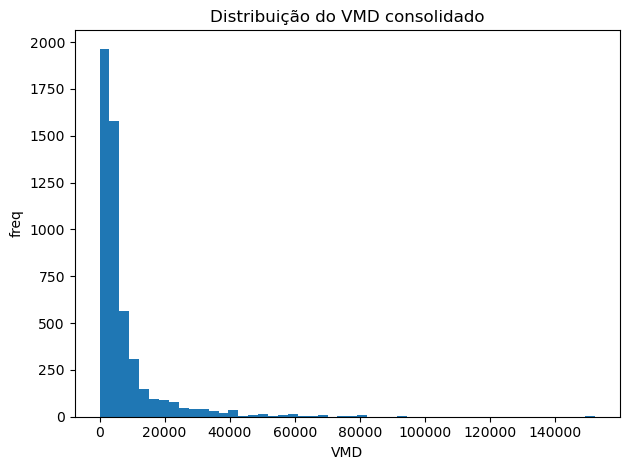

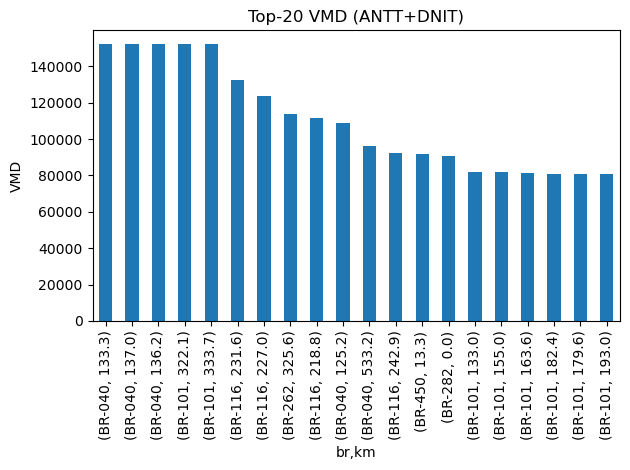

In [45]:
# 4_flux_unifica.py  ───────────────────────────────────────────
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
# opcional ─ use geopandas apenas se quiser o join espacial
try:
    import geopandas as gpd
except ImportError:
    gpd = None   # será checado mais adiante

# ── 0. Configs simples ───────────────────────────────────────
CACHE = Path("cache")
FN_ANTT = CACHE / "antt_flux.parquet"
FN_DNIT = CACHE / "dnit_vmda_2023.parquet"
FN_OUT  = CACHE / "flux_all.parquet"

# shape/geojson de referência (opcional)
# se não quiser geo-join, deixe SHP=None
SHP = Path("dados/eixos_snv.geojson")   # ou shapefile .shp

# ── 1. Carrega   ─────────────────────────────────────────────
df_antt = pd.read_parquet(FN_ANTT)
df_dnit = pd.read_parquet(FN_DNIT)

print("ANTT:", df_antt.shape)
print("DNIT:", df_dnit.shape)

# ── 2. União vertical ────────────────────────────────────────
flux_all = pd.concat([df_antt, df_dnit], ignore_index=True)
print("Após concat:", flux_all.shape)

# ── 3. Resolver duplicidades BR-KM ───────────────────────────
# regra: manter a MAIOR VMD dentre as fontes
flux_all = (flux_all.sort_values("vmd", ascending=False)
                      .drop_duplicates(subset=["br", "km"], keep="first"))

# se preferir média em vez de maior valor, use:
# flux_all = (flux_all.groupby(["br","km"], as_index=False)["vmd"].mean())

print("Após drop_duplicates:", flux_all.shape)

# ── 4. Estatísticas básicas / sanity-check ───────────────────
print("\nResumo estatístico:")
print(flux_all["vmd"].describe(percentiles=[.05,.25,.5,.75,.95]))

print("\nTop-20 maiores VMD:")
print(flux_all.nlargest(20, "vmd")[["br","km","vmd","src"]])

# ── 5. Salva  ────────────────────────────────────────────────
FN_OUT.parent.mkdir(exist_ok=True)
flux_all.to_parquet(FN_OUT, index=False)
print(f"\n✓ Parquet consolidado salvo em {FN_OUT.resolve()}")

# ── 6. Geo-join opcional ─────────────────────────────────────
if SHP and SHP.exists():
    if gpd is None:
        print("\n⚠ GeoPandas não instalado – pulei join espacial.")
    else:
        print("\n• Fazendo join espacial…")
        # Carrega shape/geojson (precisa ter colunas 'br' e 'km' p/ merge direto
        # OU geometria + sjoin_nearest;  aqui assumo merge direto)
        gdf_eixos = gpd.read_file(SHP)
        # normaliza chaves
        gdf_eixos["br"] = gdf_eixos["br"].str.upper().str.strip()
        gdf_eixos["km"] = pd.to_numeric(gdf_eixos["km"], errors="coerce")

        gdf_join = (gdf_eixos.merge(flux_all, on=["br","km"], how="inner")
                               .set_crs(gdf_eixos.crs))

        out_geo = CACHE / "flux_all_geo.parquet"
        gdf_join.to_parquet(out_geo, index=False)
        print(f"✓ GeoParquet salvo em {out_geo.resolve()}  ({len(gdf_join)} linhas)")

# ── 7. Gráficos rápidos  ─────────────────────────────────────
plt.figure()
flux_all["vmd"].plot(kind="hist", bins=50)
plt.title("Distribuição do VMD consolidado")
plt.xlabel("VMD")
plt.ylabel("freq")
plt.tight_layout()
plt.show()

plt.figure()
flux_all.nlargest(20, "vmd").set_index(["br","km"])["vmd"].plot(kind="bar")
plt.title("Top-20 VMD (ANTT+DNIT)")
plt.ylabel("VMD")
plt.tight_layout()
plt.show()

In [19]:
# build_pontos_parquet.py  – exemplo mínimo
import pandas as pd, json
from pathlib import Path

RAW = Path("dados/pontos.json").read_text(encoding="utf-8")
items = json.loads(RAW)

rows = []
for it in items:
    ai = it.get("AddressInfo", {})
    for c in it.get("Connections", []):
        power = (
            c.get("PowerKW") or                 # já vem calculado?
            (c.get("Voltage") or 0) * (c.get("Amps") or 0) / 1000
        )
        rows.append({
            "name": ai.get("Title", "sem nome"),
            "lat": ai.get("Latitude"),
            "lon": ai.get("Longitude"),
            "power_kW": power or 50,            # fallback: 50 kW
        })

df = pd.DataFrame(rows).dropna(subset=["lat", "lon"])
df.to_parquet("cache/parquet/pontos.parquet", index=False)

In [23]:
from pathlib import Path
import pandas as pd, re, warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

PARQ_DIR = Path("cache/parquet")

def parece_coord(col):
    return bool(re.search(r"(lat|lon|long|coord)", col, re.I))

for pq in PARQ_DIR.glob("*.parquet"):
    try:
        df = pd.read_parquet(pq, engine="pyarrow")      # carrega inteiro
        cols = list(df.columns)
        latlon = [c for c in cols if parece_coord(c)]
        print(f"▪ {pq.name:<25}  linhas={len(df):7d}  cols={len(cols):2d}  "
              f"[coord: {', '.join(latlon) or '—'}]")
    except Exception as e:
        print(f"⚠ {pq.name:<25}  erro ao ler: {e}")

▪ flux_all.parquet           linhas=   5132  cols= 4  [coord: —]
▪ demand_by_node.parquet     linhas=      1  cols= 2  [coord: —]
▪ supply_existing.parquet    linhas=    212  cols= 3  [coord: —]
▪ dnit_vmda_2023.parquet     linhas=   5577  cols= 4  [coord: —]
▪ pbev_2025.parquet          linhas=    726  cols=28  [coord: —]
▪ antt_flux.parquet          linhas=    101  cols= 4  [coord: —]
▪ pbev_2025_clean.parquet    linhas=      0  cols= 0  [coord: —]
▪ cadastro_pracas.parquet    linhas=    246  cols= 5  [coord: lat, lon]
▪ pontos.parquet             linhas=    406  cols= 4  [coord: lat, lon]


In [26]:
import geopandas as gpd
print(gpd.read_file("dados/202504A/SNV_202504A.shp", rows=1).columns)

Index(['id_trecho_', 'vl_br', 'sg_uf', 'nm_tipo_tr', 'sg_tipo_tr',
       'desc_coinc', 'vl_codigo', 'ds_local_i', 'ds_local_f', 'vl_km_inic',
       'vl_km_fina', 'vl_extensa', 'ds_sup_fed', 'ds_obra', 'ul', 'ds_coinc',
       'ds_tipo_ad', 'ds_ato_leg', 'est_coinc', 'sup_est_co', 'ds_jurisdi',
       'ds_superfi', 'ds_legenda', 'sg_legenda', 'leg_multim', 'versao_snv',
       'id_versao', 'marcador', 'geometry'],
      dtype='object')


In [27]:
#!/usr/bin/env python3
# geocode_dnit_km.py
from pathlib import Path
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# ───────── paths ─────────────────
BASE      = Path("cache/parquet")
SHAPE_DIR = Path("dados/202504A")
SHAPEFILE = SHAPE_DIR / "SNV_202504A.shp"   # ajuste se nome mudar

# ───────── 1. malha rodoviária ─────────
print("• lendo shapefile…")
gdf = gpd.read_file(SHAPEFILE, encoding="latin1")        # DNIT usa Latin-1

COL_BR = "vl_br"      # <-- campo correto para o seu arquivo 202504A

gdf["br"] = (
    gdf[COL_BR]
      .astype(int)            # 40  →  40
      .astype(str)            # "40"
      .str.zfill(3)           # "040"
      .radd("BR-")            # "BR-040"
)

gdf = gdf.to_crs(5880)        # SIRGAS-2000 / Brazil Polyconic (metres)

# ───────── 2. dados DNIT VMDA ───
dnit = pd.read_parquet(BASE / "dnit_vmda_2023.parquet")   # br, km, vmd …

# normaliza BR igual ao shapefile
dnit["br"] = (dnit["br"]
                .str.strip()
                .str.replace(r"\s+", "", regex=True)
                .str.upper())

# ───────── 3. gera lat/lon ───────
coords = []
for idx, row in dnit.iterrows():
    segs = gdf[gdf["br"] == row.br]
    if segs.empty:
        coords.append((pd.NA, pd.NA))
        continue

    # se a BR aparecer em vários trechos, pega o 1º;
    # para maior precisão somei todos num MultiLineString
    line = segs.unary_union      # shapely LineString/MultiLineString
    # distancia em metros ao longo do eixo
    dist_m = float(row.km) * 1000.0
    # se km > comprimento, devolve último vértice
    dist_m = min(dist_m, line.length)
    point_m = line.interpolate(dist_m)

    # volta para WGS-84
    point_wgs = gpd.GeoSeries([point_m], crs=5880).to_crs(4326).iloc[0]
    coords.append((point_wgs.y, point_wgs.x))   # lat, lon

dnit[["lat", "lon"]] = coords

# ───────── 4. salva ──────────────
out = BASE / "dnit_vmda_coord.parquet"
dnit.to_parquet(out, index=False)
print(f"✓ salvo {out}  –  {len(dnit):,} linhas")

# preview rápido
print(dnit.head())

• lendo shapefile…


/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/1232802873.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line = segs.unary_union      # shapely LineString/MultiLineString
/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/1232802873.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line = segs.unary_union      # shapely LineString/MultiLineString
/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/1232802873.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line = segs.unary_union      # shapely LineString/MultiLineString
/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/1232802873.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line = segs.unary_union      # shapely LineString/MultiLin

✓ salvo cache/parquet/dnit_vmda_coord.parquet  –  5,577 linhas
       br     km    vmd   src        lat        lon
0  BR-116  183.8   5767  DNIT  -9.517316 -39.106920
1  BR-116  214.8  15369  DNIT  -9.780687 -39.136863
2  BR-116  194.6  11723  DNIT  -9.611124 -39.102613
3  BR-448    0.0  11800  DNIT -29.827417 -51.172653
4  BR-392  120.7   3220  DNIT -31.631082 -52.497032


In [36]:
import geopandas as gpd, pandas as pd, re, pathlib
SNV = gpd.read_file("dados/202504A/SNV_202504A.shp", encoding="latin1")

# veja como a BR aparece de verdade
print("Exemplo bruto:", SNV["vl_br"].unique()[:20])

# crie uma coluna *limpa* para entender os padrões
def normaliza(x):
    x = str(x).upper().strip()
    x = re.sub(r"[^\dA-Z]", "", x)      # tira hífens, barras, espaços
    if not x.startswith("BR"):          # se vier só "040", prefixa
        x = "BR" + x.zfill(3)
    return x

SNV["br_norm"] = SNV["vl_br"].map(normaliza)
print("Exemplo normalizado:", SNV["br_norm"].unique()[:20])

print("\n‣ Quantas BR diferentes no shapefile?",
      SNV["br_norm"].nunique())

Exemplo bruto: ['010' '020' '030' '040' '050' '060' '070' '080' '101' '104' '110' '116'
 '120' '122' '135' '146' '153' '154' '155' '156']
Exemplo normalizado: ['BR010' 'BR020' 'BR030' 'BR040' 'BR050' 'BR060' 'BR070' 'BR080' 'BR101'
 'BR104' 'BR110' 'BR116' 'BR120' 'BR122' 'BR135' 'BR146' 'BR153' 'BR154'
 'BR155' 'BR156']

‣ Quantas BR diferentes no shapefile? 167


In [42]:
#!/usr/bin/env python3
# geocode_antt_flux.py  –  ANTT (VMD) ➜ pontos georreferenciados
# ---------------------------------------------------------------

from pathlib import Path
import re, unicodedata, warnings
import numpy as np                       #  << aqui
import pandas as pd, geopandas as gpd
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

BASE       = Path("cache/parquet")
SNV_SHAPE  = Path("dados/202504A/SNV_202504A.shp")
PARQ_IN    = BASE / "antt_flux.parquet"
PARQ_OUT   = BASE / "antt_flux_coord.parquet"

def norm_br(txt: str) -> str:
    txt = unicodedata.normalize("NFKD", str(txt).upper()).encode("ascii","ignore").decode()
    txt = re.sub(r"[^0-9]", "", txt)
    return f"BR{txt.zfill(3)}" if txt else "UNK"

# ───────── 1. malha SNV ───────────────────────────────────────────────
print("• lendo shapefile (SNV)…")
gdf = gpd.read_file(SNV_SHAPE, encoding="latin1")
gdf["br_norm"] = gdf["vl_br"].map(norm_br)
gdf["km_ini"]  = gdf["vl_km_inic"].astype(float)
gdf["km_fim"]  = gdf["vl_km_fina"].astype(float)
gdf            = gdf.to_crs(5880)               # CRS em metros
br_idx         = {br: seg for br, seg in gdf.groupby("br_norm")}

# ───────── 2. fluxo ANTT ─────────────────────────────────────────────-
flux = pd.read_parquet(PARQ_IN)
flux["br_norm"] = flux["br"].map(norm_br)

# *** AQUI o detalhe: use np.nan, não pd.NA ***
flux["lat"] = np.nan
flux["lon"] = np.nan
# ---------------------------------------------

# ───────── 3. geocodificação exata ------------------------------------
ok = 0
for i, r in flux.iterrows():
    segs = br_idx.get(r.br_norm)
    if segs is None:
        continue

    seg_row = segs[(segs["km_ini"] <= r.km) & (r.km <= segs["km_fim"])]
    line    = (seg_row.unary_union if not seg_row.empty else segs.unary_union)

    km0     = float(seg_row.iloc[0]["km_ini"]) if not seg_row.empty else 0.0
    offset  = min(max((r.km - km0) * 1000, 0.0), line.length)

    p_m   = line.interpolate(offset)
    p_wgs = gpd.GeoSeries([p_m], crs=5880).to_crs(4326).iloc[0]
    flux.at[i, "lat"] = p_wgs.y
    flux.at[i, "lon"] = p_wgs.x
    ok += 1

print(f"• coordenadas atribuídas a {ok} / {len(flux)} registros")

# ───────── 4. interpolação linear (opção B) para faltantes ------------
missing = flux["lat"].isna().sum()
if missing:
    print(f"• preenchendo {missing} faltantes via interpolação linear…")
    flux.sort_values(["br_norm", "km"], inplace=True)

    def interp_grp(g):
        if g["lat"].notna().any():
            g[["lat", "lon"]] = g[["lat", "lon"]].interpolate("linear")\
                                                 .bfill().ffill()
        return g

    flux = (flux.groupby("br_norm", group_keys=False)
                .apply(interp_grp))

    print("  faltantes restantes:", int(flux['lat'].isna().sum()))

# ───────── 5. salvar --------------------------------------------------
flux.to_parquet(PARQ_OUT, index=False)
print(f"✓ salvo {PARQ_OUT} – {len(flux):,} linhas")
print(flux.head())

• lendo shapefile (SNV)…
• coordenadas atribuídas a 99 / 101 registros
• preenchendo 2 faltantes via interpolação linear…
  faltantes restantes: 2
✓ salvo cache/parquet/antt_flux_coord.parquet – 101 linhas
       br      km  vmd   src br_norm        lat        lon
0  BR-040   45.50   11  ANTT   BR040 -16.404393 -47.823029
1  BR-040  102.00   11  ANTT   BR040 -16.799173 -47.568752
2  BR-040  577.20   12  ANTT   BR040 -20.272641 -43.951737
3  BR-040  642.85    8  ANTT   BR040 -20.759969 -43.805513
4  BR-040  714.10    8  ANTT   BR040 -21.245133 -43.687043


/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/2178073522.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line    = (seg_row.unary_union if not seg_row.empty else segs.unary_union)
/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/2178073522.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line    = (seg_row.unary_union if not seg_row.empty else segs.unary_union)
/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/2178073522.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line    = (seg_row.unary_union if not seg_row.empty else segs.unary_union)
/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/2178073522.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  line    = (seg_row.unary_union 

In [43]:
#!/usr/bin/env python3
"""
Gera cache/parquet/flux_all.parquet a partir de:

    • cache/parquet/dnit_vmda_coord.parquet
    • cache/parquet/antt_flux_coord.parquet
       (ambos precisam ter colunas: br, km, vmd, lat, lon)
"""

from pathlib import Path
import pandas as pd

BASE = Path("cache/parquet")

# ----- ler e padronizar ------------------------------------------------
dnit = pd.read_parquet(BASE / "dnit_vmda_coord.parquet").copy()
dnit["src"] = "DNIT"

antt = pd.read_parquet(BASE / "antt_flux_coord.parquet").copy()
antt["src"] = "ANTT"

# mantemos somente as colunas-chave (na ordem desejada)
keep = ["br", "km", "vmd", "lat", "lon", "src"]
flux = (pd.concat([dnit[keep], antt[keep]], ignore_index=True)
          .dropna(subset=["lat", "lon"]))          # descarta remanescentes

# ----- salvar ----------------------------------------------------------
out = BASE / "flux_all.parquet"
flux.to_parquet(out, index=False)
print(f"✓ salvo {out}  –  {len(flux):,} linhas")
print(flux.head())

✓ salvo cache/parquet/flux_all.parquet  –  5,676 linhas
       br     km    vmd        lat        lon   src
0  BR-116  183.8   5767  -9.517316 -39.106920  DNIT
1  BR-116  214.8  15369  -9.780687 -39.136863  DNIT
2  BR-116  194.6  11723  -9.611124 -39.102613  DNIT
3  BR-448    0.0  11800 -29.827417 -51.172653  DNIT
4  BR-392  120.7   3220 -31.631082 -52.497032  DNIT


In [44]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Cria:
  • cache/parquet/demand_by_node.parquet   (nó, kWh_dia)
  • cache/parquet/supply_existing.parquet  (nó, pot_kW_total, n_chargers)

A partir de:
  • cache/graph_Brazil.graphml
  • cache/parquet/flux_all.parquet
  • cache/parquet/pontos.parquet
"""

from pathlib import Path
import osmnx as ox, pandas as pd, numpy as np

# ───────── parâmetros globais ─────────────────────────────────────────
AUTONOMIA_KM        = 400      # alcance médio do EV
CONSUMO_KWH_100KM   = 15       # kWh por 100 km
EV_SHARE            = 0.01     # 1 % da frota

# ───────── caminhos ───────────────────────────────────────────────────
BASE = Path("cache/parquet")
G    = ox.load_graphml("cache/graph_Brazil.graphml")

# ---------------------------------------------------------------------
# 1. DEMANDA
# ---------------------------------------------------------------------
flux = pd.read_parquet(BASE / "flux_all.parquet")   # br, km, vmd, lat, lon, src

if {"lat", "lon"}.issubset(flux.columns):
    lat = flux["lat"].astype(float).values
    lon = flux["lon"].astype(float).values
else:
    raise ValueError("flux_all.parquet precisa ter colunas 'lat' e 'lon'.")

# nó OSM mais próximo
nodes = ox.nearest_nodes(G, lon, lat)

flux = (flux.assign(node      = nodes,
                    ev_vmd    = flux["vmd"] * EV_SHARE,
                    kWh_dia   = flux["vmd"] * EV_SHARE
                                 * AUTONOMIA_KM * CONSUMO_KWH_100KM / 100)
             .astype({"node": "int64"}))

dem = (flux.groupby("node", as_index=False)["kWh_dia"]
            .sum())

dem.to_parquet(BASE / "demand_by_node.parquet", index=False)

# ---------------------------------------------------------------------
# 2. OFERTA EXISTENTE (OpenChargeMap)
# ---------------------------------------------------------------------
ocm = pd.read_parquet(BASE / "pontos.parquet")   # lon, lat, power_kW

nodes = ox.nearest_nodes(G, ocm["lon"].values, ocm["lat"].values)
ocm["node"] = nodes

sup = (ocm.groupby("node", as_index=False)
          .agg(n_chargers   = ("power_kW", "size"),
               pot_kW_total = ("power_kW", "sum"))
          .astype({"node": "int64"}))

sup.to_parquet(BASE / "supply_existing.parquet", index=False)

print("✓ demand_by_node.parquet  | linhas:", len(dem))
print("✓ supply_existing.parquet | linhas:", len(sup))

✓ demand_by_node.parquet  | linhas: 3208
✓ supply_existing.parquet | linhas: 212


In [45]:
#!/usr/bin/env python3
# 00_merge_flux.py — combina ANTT e DNIT já geocodificados em flux_all.parquet

from pathlib import Path
import pandas as pd

BASE   = Path("cache/parquet")
ANTT   = BASE / "antt_flux_coord.parquet"
DNIT   = BASE / "dnit_vmda_coord.parquet"
OUT    = BASE / "flux_all.parquet"

# lê
df_ant = pd.read_parquet(ANTT)    # br, km, vmd, src, br_norm, lat, lon
df_dni = pd.read_parquet(DNIT)    # br, km, vmd, src, lat, lon

# concatena
flux_all = pd.concat([df_ant, df_dni], ignore_index=True)

# opcional: joga fora qualquer linha sem coordenada
flux_all = flux_all.dropna(subset=["lat","lon"])

flux_all.to_parquet(OUT, index=False)
print("✓ flux_all.parquet  | linhas:", len(flux_all))

✓ flux_all.parquet  | linhas: 5676


In [46]:
#!/usr/bin/env python3
# 00_prepare_data.py — lê grafo + flux_all + pontos → demanda|oferta por nó

from pathlib import Path
import numpy as np
import osmnx as ox, pandas as pd

# ─── parâmetros fixos ─────────────────────────────
AUTONOMIA_KM      = 400    # km
CONSUMO_KWH_100KM = 15     # kWh/100 km
EV_SHARE          = 0.01   # 1 %

BASE = Path("cache/parquet")
G    = ox.load_graphml("cache/graph_Brazil.graphml")

# --- 1) DEMANDA -------------------------------------------------------
flux = pd.read_parquet(BASE/"flux_all.parquet")  # tem lat, lon, vmd

# mapeia cada ponto de fluxo ao nó mais próximo
nodes = ox.nearest_nodes(
    G,
    flux["lon"].values,
    flux["lat"].values
)
flux = flux.assign(
    node    = nodes,
    ev_vmd  = flux["vmd"] * EV_SHARE,
    kWh_dia = flux["vmd"] * EV_SHARE
              * AUTONOMIA_KM * CONSUMO_KWH_100KM / 100
)

dem = (flux
       .groupby("node", as_index=False)["kWh_dia"]
       .sum()
       .astype({"node": "int64"}))

dem.to_parquet(BASE/"demand_by_node.parquet", index=False)

# --- 2) OFERTA EXISTENTE --------------------------------------------
ocm = pd.read_parquet(BASE/"pontos.parquet")  # lon, lat, power_kW
nodes = ox.nearest_nodes(G, ocm["lon"], ocm["lat"])
ocm["node"] = nodes

sup = (ocm
       .groupby("node", as_index=False)
       .agg(n_chargers   = ("power_kW", "size"),
            pot_kW_total = ("power_kW", "sum"))
       .astype({"node": "int64"}))

sup.to_parquet(BASE/"supply_existing.parquet", index=False)

print("✓ demand_by_node.parquet  | linhas:", len(dem))
print("✓ supply_existing.parquet | linhas:", len(sup))

✓ demand_by_node.parquet  | linhas: 3208
✓ supply_existing.parquet | linhas: 212


In [48]:
#!/usr/bin/env python3
# create_demand_by_state.py — anexa UF à demanda e salva parquet por experimento

import pandas as pd
import geopandas as gpd
from geobr import read_state
from shapely.geometry import Point
from pathlib import Path

# ─────────────── PARÂMETROS ───────────────
BASE       = Path("cache/parquet")
DEM_PARQ   = BASE / "demand_by_node.parquet"
EXP_NAME   = "experiment1"              # mude para cada experimento
OUT_PARQ   = BASE / f"demand_by_state.parquet"
YEAR_SHAPE = 2020                       # ano de referência para o shapefile

# ─────────────── 1) lê demanda ───────────────
dem = pd.read_parquet(DEM_PARQ)         # colunas: node, kWh_dia

# ─────────────── 2) mapeia coordenadas ───────────────
# (supondo que você já carregou o grafo em outra parte do seu pipeline)
import osmnx as ox
G = ox.load_graphml("cache/graph_Brazil.graphml")
lon = {n: d["x"] for n,d in G.nodes(data=True)}
lat = {n: d["y"] for n,d in G.nodes(data=True)}
dem["lon"] = dem["node"].map(lon)
dem["lat"] = dem["node"].map(lat)

# ─────────────── 3) cria GeoDataFrame de pontos ───────────────
gdem = gpd.GeoDataFrame(
    dem,
    geometry=[Point(xy) for xy in zip(dem.lon, dem.lat)],
    crs="EPSG:4326"
)

# ─────────────── 4) carrega limites estaduais ───────────────
states = read_state(year=YEAR_SHAPE)[["abbrev_state", "geometry"]]

# ─────────────── 5) spatial join ───────────────
# usa 'within' para garantir que cada ponto caia no polígono correto
gdem_uf = gpd.sjoin(
    gdem,
    states.rename(columns={"abbrev_state": "UF"}),
    how="left",
    predicate="within"
).drop(columns=["index_right"])

# ─────────────── 6) salva parquet separado ───────────────
# transformamos de volta em DataFrame "plano" para economizar espaço
df_out = pd.DataFrame({
    "node":    gdem_uf["node"],
    "kWh_dia": gdem_uf["kWh_dia"],
    "lon":     gdem_uf["lon"],
    "lat":     gdem_uf["lat"],
    "UF":      gdem_uf["UF"].fillna("UNK")  
})

df_out.to_parquet(OUT_PARQ, index=False)
print(f"✓ Demanda por estado salva em {OUT_PARQ}")

✓ Demanda por estado salva em cache/parquet/demand_by_state.parquet


/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_61471/1112918933.py:41: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674

  gdem_uf = gpd.sjoin(


### Cabeçalho:


,br,km,vmd,src,br_norm,lat,lon
0,BR-040,45.50,11,ANTT,BR040,-16.404393,-47.823029
1,BR-040,102.00,11,ANTT,BR040,-16.799173,-47.568752
2,BR-040,577.20,12,ANTT,BR040,-20.272641,-43.951737
3,BR-040,642.85,8,ANTT,BR040,-20.759969,-43.805513
4,BR-040,714.10,8,ANTT,BR040,-21.245133,-43.687043



### Tipos e shape:
br          object
km         float64
vmd          Int64
src         object
br_norm     object
lat        float64
lon        float64
dtype: object 

Shape: (5676, 7)

### Estatísticas numéricas:


,km,vmd,lat,lon
count,5676.000000,5676.0,5676.000000,5676.000000
mean,243.970080,7498.386892,-15.718972,-46.712717
std,224.677504,11640.944815,7.210738,7.727629
min,0.000000,1.0,-33.529571,-73.687577
25%,64.900000,2360.75,-21.221188,-51.514880
50%,179.000000,3877.5,-15.816518,-46.047715
75%,367.900000,7431.5,-9.686818,-40.124694
max,1193.900000,152281.0,3.374593,-34.908584



### Rodovias únicas (br):
br
BR-101    416
BR-116    343
BR-153    249
BR-163    219
BR-158    165
BR-364    165
BR-174    142
BR-262    135
BR-230    131
BR-135    114
Name: count, dtype: int64

### Fontes dos dados (src):
src
DNIT    5577
ANTT      99
Name: count, dtype: int64

### br_norm (código unificado):
br_norm
BR101    16
BR116    15
BR153    14
BR163    11
BR364     7
BR050     6
BR040     6
BR262     5
BR386     4
BR277     2
Name: count, dtype: int64

### Pontos de fluxo por estado:
UF
AC     160
AL     413
AM     281
BA    1047
CE     226
DF      73
ES     150
GO     742
MA     107
MG     804
MS     293
MT      42
PA      30
PB      76
PE      56
PI      46
PR     387
RJ      95
RN      62
RO      25
RR      13
RS     338
SC     119
SE       2
SP      85
TO       4
Name: count, dtype: int64


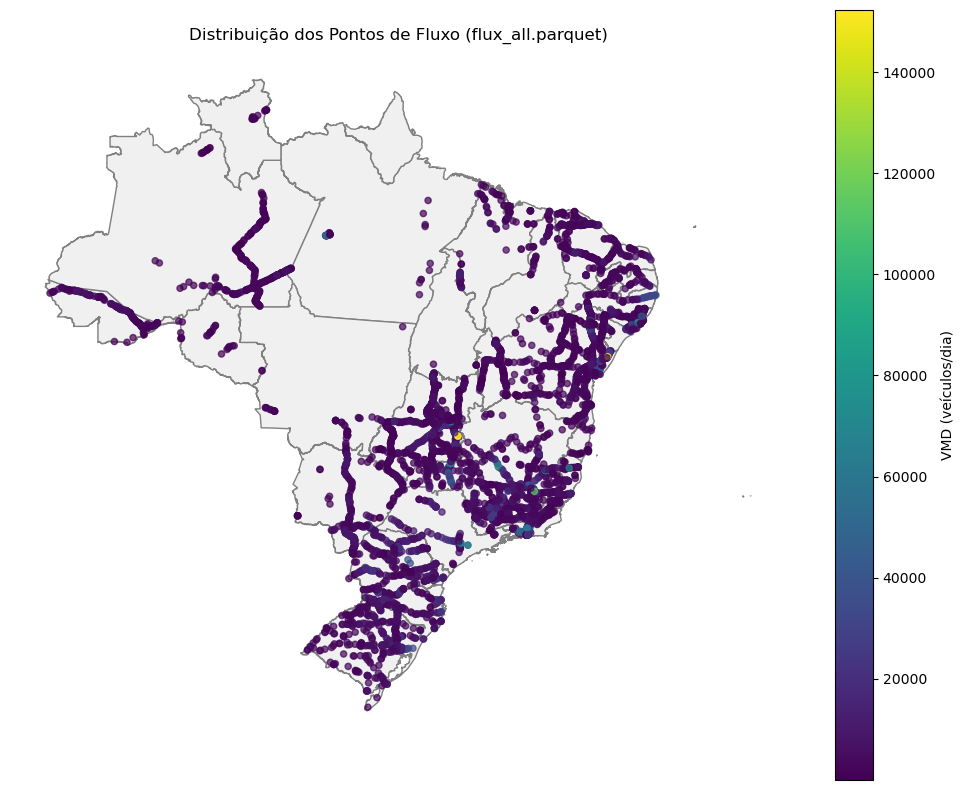

In [ ]:
# %% [markdown]
# # Explorando o fluxo de veículos (`flux_all.parquet`)

# %%
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import Point
import numpy as np
import geobr   # pip install geobr

# ─────────── Localiza cache/parquet ───────────
HERE = Path().resolve()
CUR = HERE
while CUR != CUR.parent:
    if (CUR / "cache" / "parquet").is_dir():
        PARQUET_DIR = CUR / "cache" / "parquet"
        break
    CUR = CUR.parent
else:
    raise FileNotFoundError("Não encontrei cache/parquet acima de " + str(HERE))

# ─────────── Carrega malha de estados via geobr ───────────
# NÃO usamos set_crs (já vem com CRS), apenas projetamos para 4326 se necessário
ufs = (
    geobr.read_state(year=2020)[["abbrev_state","geometry"]]
    .rename(columns={"abbrev_state":"UF"})
    .to_crs(epsg=4326)
)

# ─────────── Carrega flux_all ───────────
flux = pd.read_parquet(PARQUET_DIR / "flux_all.parquet")

# primeiras linhas
print("### Cabeçalho:")
display(flux.head())

print("\n### Tipos e shape:")
print(flux.dtypes, "\n")
print(f"Shape: {flux.shape}")

print("\n### Estatísticas numéricas:")
display(flux[["km","vmd","lat","lon"]].describe())

print("\n### Rodovias únicas (br):")
print(flux["br"].value_counts().head(10))

print("\n### Fontes dos dados (src):")
print(flux["src"].value_counts())

print("\n### br_norm (código unificado):")
print(flux["br_norm"].value_counts().head(10))

# ─────────── Converte em GeoDataFrame ───────────
gflux = gpd.GeoDataFrame(
    flux.assign(geometry=[Point(xy) for xy in zip(flux.lon, flux.lat)]),
    crs="EPSG:4326"
)

# ─────────── Spatial‐join com UF ───────────
gflux = gpd.sjoin(gflux, ufs, how="left", predicate="within")

print("\n### Pontos de fluxo por estado:")
print(gflux["UF"].value_counts().sort_index())

# ─────────── Mapa dos pontos de fluxo ───────────
fig, ax = plt.subplots(1,1,figsize=(10,8))
ufs.plot(ax=ax, color="#f0f0f0", edgecolor="gray")
gflux.plot(
    ax=ax,
    column="vmd",
    cmap="viridis",
    markersize=20,
    legend=True,
    legend_kwds={"label":"VMD (veículos/dia)"},
    alpha=0.7
)
ax.set_title("Distribuição dos Pontos de Fluxo (flux_all.parquet)")
ax.set_axis_off()
plt.tight_layout()
plt.show()